## 载入数据

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

In [3]:
target_url = ("http://archive.ics.uci.edu/ml/machine-"
              "learning-databases/abalone/abalone.data")

In [4]:
columns_mapping = {
    'Sex': '性别', 
    'Length': '长度', 
    'Diameter': '直径', 
    'Height': '高度', 
    'Whole weight': '整体重量',             
    'Shucked weight': '去壳后重量', 
    'Viscera weight': '脏器重量', 
    'Shell weight': '壳的重量',             
    'Rings': '环数'  # 目标变量
}

try:
    df_abalone = pd.read_csv("../../data/abalone.csv", header=0)
except Exception as e:
    print(e)
    df_abalone = pd.read_csv(target_url, header=None, prefix="V")
    df_abalone.columns = columns_mapping.keys()
    df_abalone.to_csv("../../data/abalone.csv", index=False)

df_abalone.head()

Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

In [5]:
nrows, ncols = df_abalone.shape
print("Number of Rows: ", nrows)
print("Number of Cols(含目标值):", ncols)

Number of Rows:  4177
Number of Cols(含目标值): 9


## 绘制鲍鱼数据的平行坐标图

需要明确鲍鱼数据和岩石vs水雷数据的不同：  
（1）岩石vs水雷：是分类任务。所以只要对不用类别样本，使用不同的颜色标识即可  
（2）鲍鱼：是回归任务，应该用不同颜色来对应不同的目标值，也就是实现目标实数值到颜色值的映射，即将目标值压缩到[0.0, 1.0]之间。  

#### 使用（x-min）/(max-min)方法，将目标值压缩到[0.0, 1.0]之间，以代表颜色值

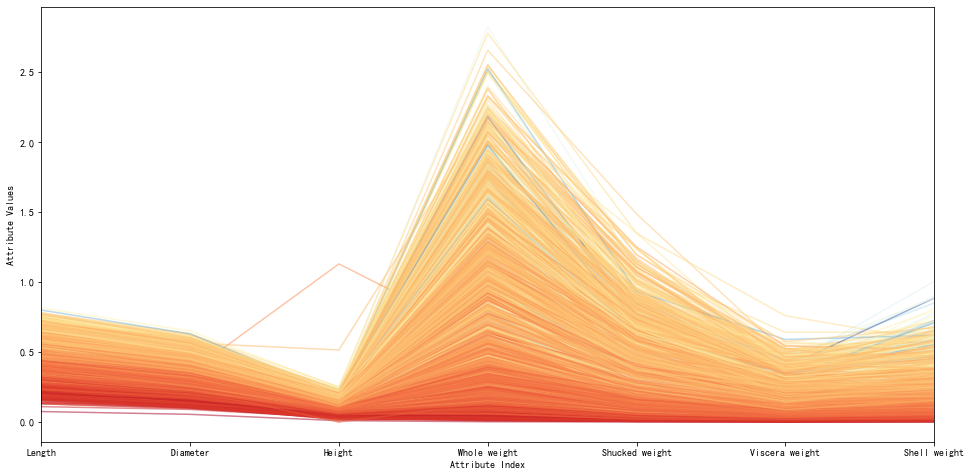

In [6]:
fig = plt.figure(figsize=(16, 8))

# 将Rings压缩到[0.0, 1.0]之间。可以使用：（x-min）/(max-min)
min_rings = df_abalone.Rings.min()
max_rings = df_abalone.Rings.max()
for i in range(nrows):
    # plot rows of data as if they were series data
    data_row = df_abalone.iloc[i, 1:8]
    label_color_value = (df_abalone.iloc[i, 8] - min_rings)/(max_rings - min_rings)
    data_row.plot(alpha=0.5, color=plt.cm.RdYlBu(label_color_value))

plt.xlabel("Attribute Index")
plt.ylabel("Attribute Values")
plt.show()

根据绘图的原理，颜色相近——说明颜色值相近（即目标值相近）。目标值相近的样本，在各个属性上如果比较一致，则图中的折线比较靠近，就会表现出比较好的区分度

#### 使用logit方法，将目标值压缩到[0.0, 1.0]之间，以代表颜色值

使用logit方法，生成颜色值有两个步骤：  
（1）z-score: (x-mean)/std。使数据的均值为0，标准差为1。这样保证了取负值和取正值的数据基本一样多，但是这并不保证数据在[0, 1]之间  
（2）外面再套一层logit函数（$logit=\frac{1}{1+e^{-x}}$）,可以将数据映射到(0, 1)之间，边界还是取不到  

In [7]:
def sigmoid(x):
    # 即上面提到logit函数
    return 1/(1 + np.exp(-x))

In [8]:
df_abalone['rings_normalized'] = (df_abalone.Rings - df_abalone.Rings.mean())/df_abalone.Rings.std()
df_abalone['color_value'] = df_abalone['rings_normalized'].apply(sigmoid)
df_abalone.head()

Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  rings_normalized  color_value  
0         0.150     15          1.571355     0.827977  
1         0.070      7         -0.909904     0.287019  
2         0.210      9         -0.289589     0.428104  
3         0.155     10          0.020568     0.505142  
4         0.055      7         -0.909904     0.287019

In [9]:
print("Min of color value: ", df_abalone['color_value'].min())
print("Max of color value: ", df_abalone['color_value'].max())

Min of color value:  0.058919938673308594
Max of color value:  0.9973047341783796


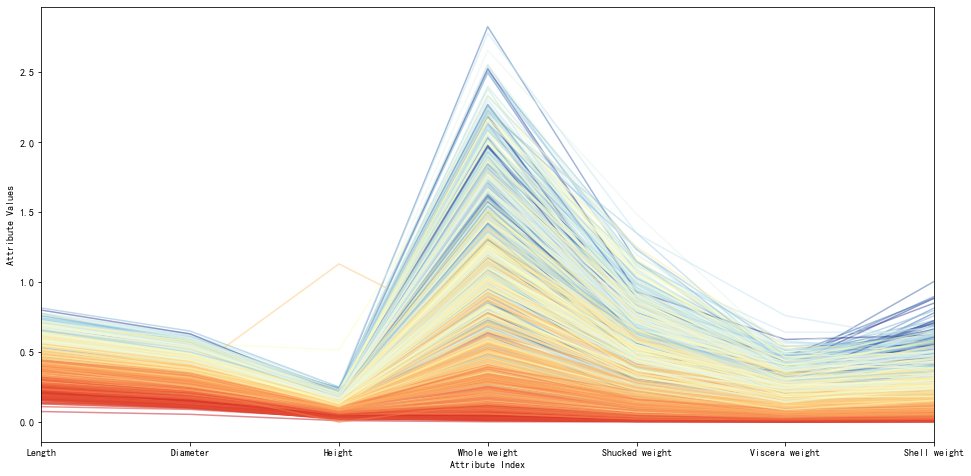

In [10]:
fig = plt.figure(figsize=(16, 8))

for i in range(nrows):
    # plot rows of data as if they were series data
    data_row = df_abalone.iloc[i, 1:8]
    label_color_value = df_abalone.iloc[i, -1]
    data_row.plot(alpha=0.5, color=plt.cm.RdYlBu(label_color_value))

plt.xlabel("Attribute Index")
plt.ylabel("Attribute Values")
plt.show()

分析：  
（1）z-score后，可以更充分的利用颜色标尺中的各种颜色  
（2）注意到：整体重量(Whole weight)、去壳后重量(Shucked weight)有些深蓝色（对应具有大环数的品种）混入了浅蓝色的区域，甚至是黄色、亮红色区域，也及时说，当鲍鱼的年龄较大时，仅仅依靠这两个（这样的）属性，不足以预测出鲍鱼的年龄（环数）  
（3）其他属性，颜色排列顺序较好，可以有效进行预测  
==》（2）、（3）有利于分析预测错误的原因